In [1]:
from xml.etree.ElementTree import PI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import os
import random
import seaborn as sns
import csv
import collections
from keras.preprocessing.image import load_img
from matplotlib.pyplot import figure
from tensorflow.python.client import device_lib
#from tensorflow.keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras import backend as K

print(device_lib.list_local_devices())
warnings.filterwarnings('ignore')

mypath = "C:/Users/sager/OneDrive/Desktop/CS5824/Project/Models/cat_dog_classifier/cat_dog_classifier/kagglecatsanddogs_3367a/petfinder-pawpularity-score"
files = [os.path.splitext(filename)[0] for filename in os.listdir(mypath + "/train")]
#print(files)

filetr = open(mypath + "/train.csv")
csvreadertr = csv.reader(filetr)

tr_data = []
for row in csvreadertr:
    tr_data.append((row[0], row[13]))
del tr_data[0]

assert(collections.Counter(list(zip(*tr_data))[0]) == collections.Counter(files))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3694288976430924071
xla_global_id: -1
]


In [2]:
df = pd.DataFrame()
df['images'] = files
df['label'] = list(zip(*tr_data))[1]
df['label'] = df['label'].astype(int)
#df = df.sample(frac=1).reset_index(drop=True)
#df.head()
#print(df)

#testlabs = to_categorical(df['label'])
#print(np.sum(np.array(testlabs)))
#print(testlabs)

[41, 31, 49, 2, 8, 85, 25, 40, 50, 76, 43, 44, 24, 25, 38, 33, 100, 64, 42, 66, 19, 34, 16, 10, 48]


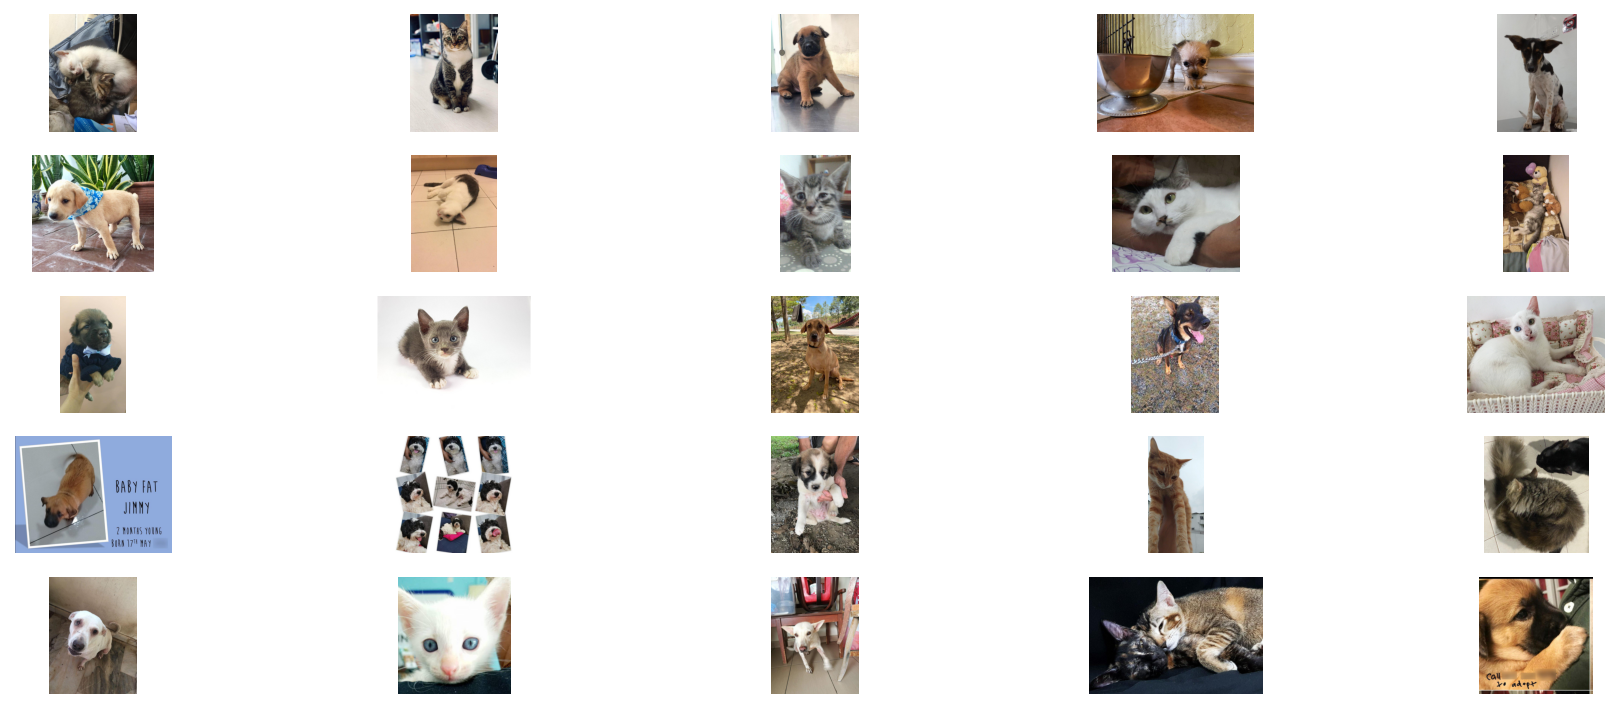

In [3]:
# Exploratory Data Analysis (dogs)
figure(figsize = (15, 6), dpi = 150)
#plt.figure(figsize=(10,7)) # display grid of images
temp = df['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

#TODO: figure out how to put ratings beneath each image
ratings = []
for index,file in enumerate(files):    
    plt.subplot(5,5,index+1)
    img = load_img(mypath + "/train/" + file + ".jpg")
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    ratings.append(np.array(df['label'][df['images'] == file])[0])

print(ratings)

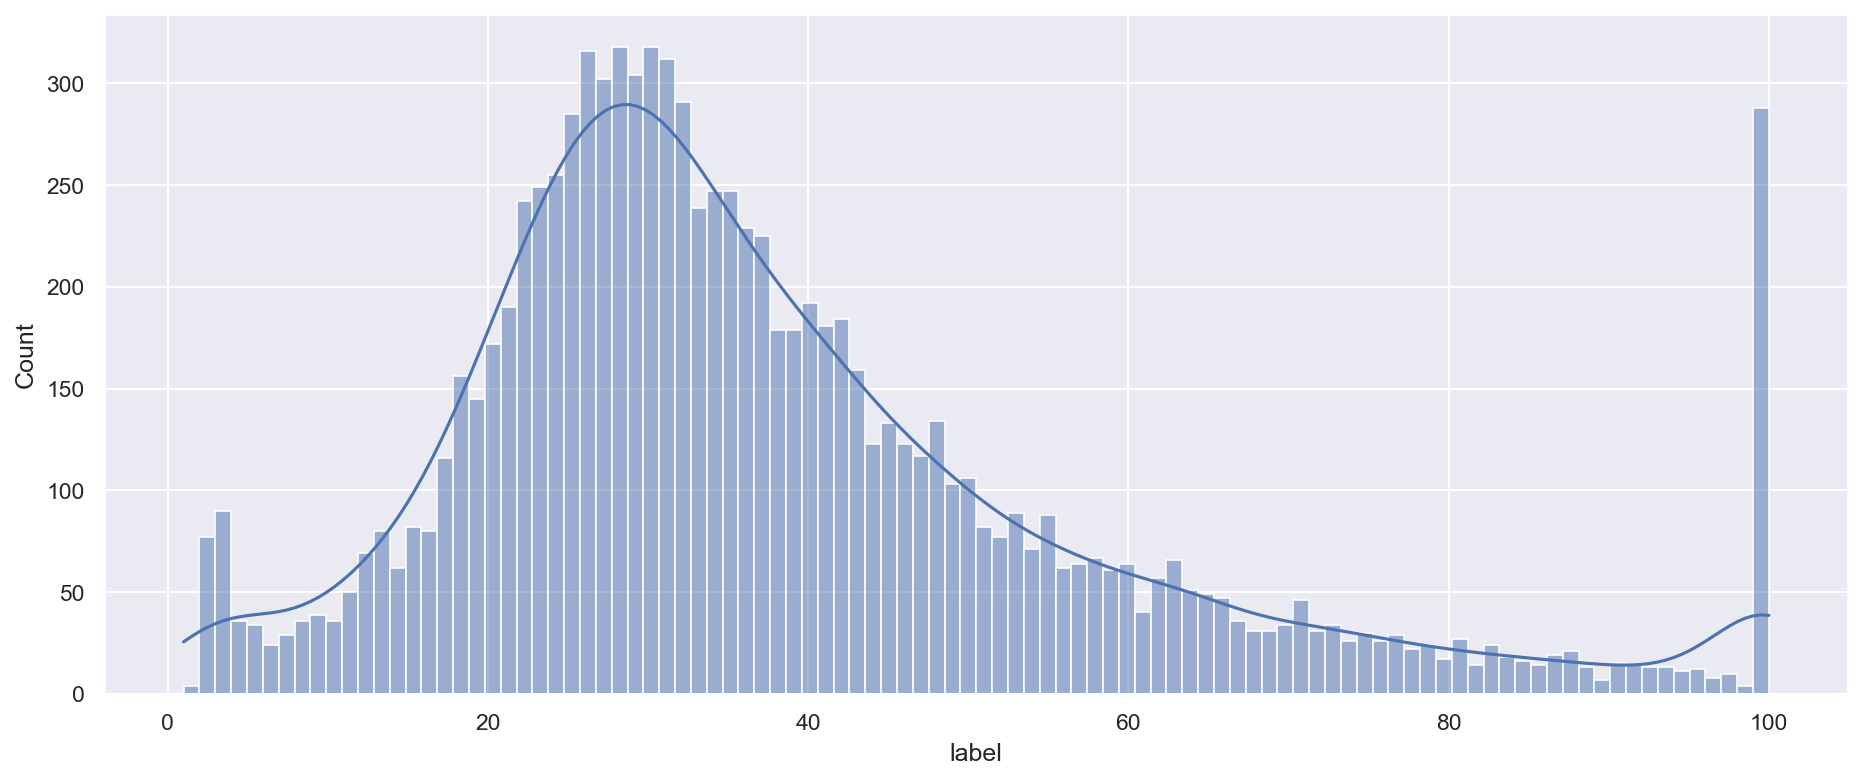

In [4]:
# show the total count for each of the labels
figure(figsize = (15, 6), dpi = 150)
sns.set(style="darkgrid")
ax = sns.histplot(df, x = 'label', bins = 100, kde = True)
plt.show()

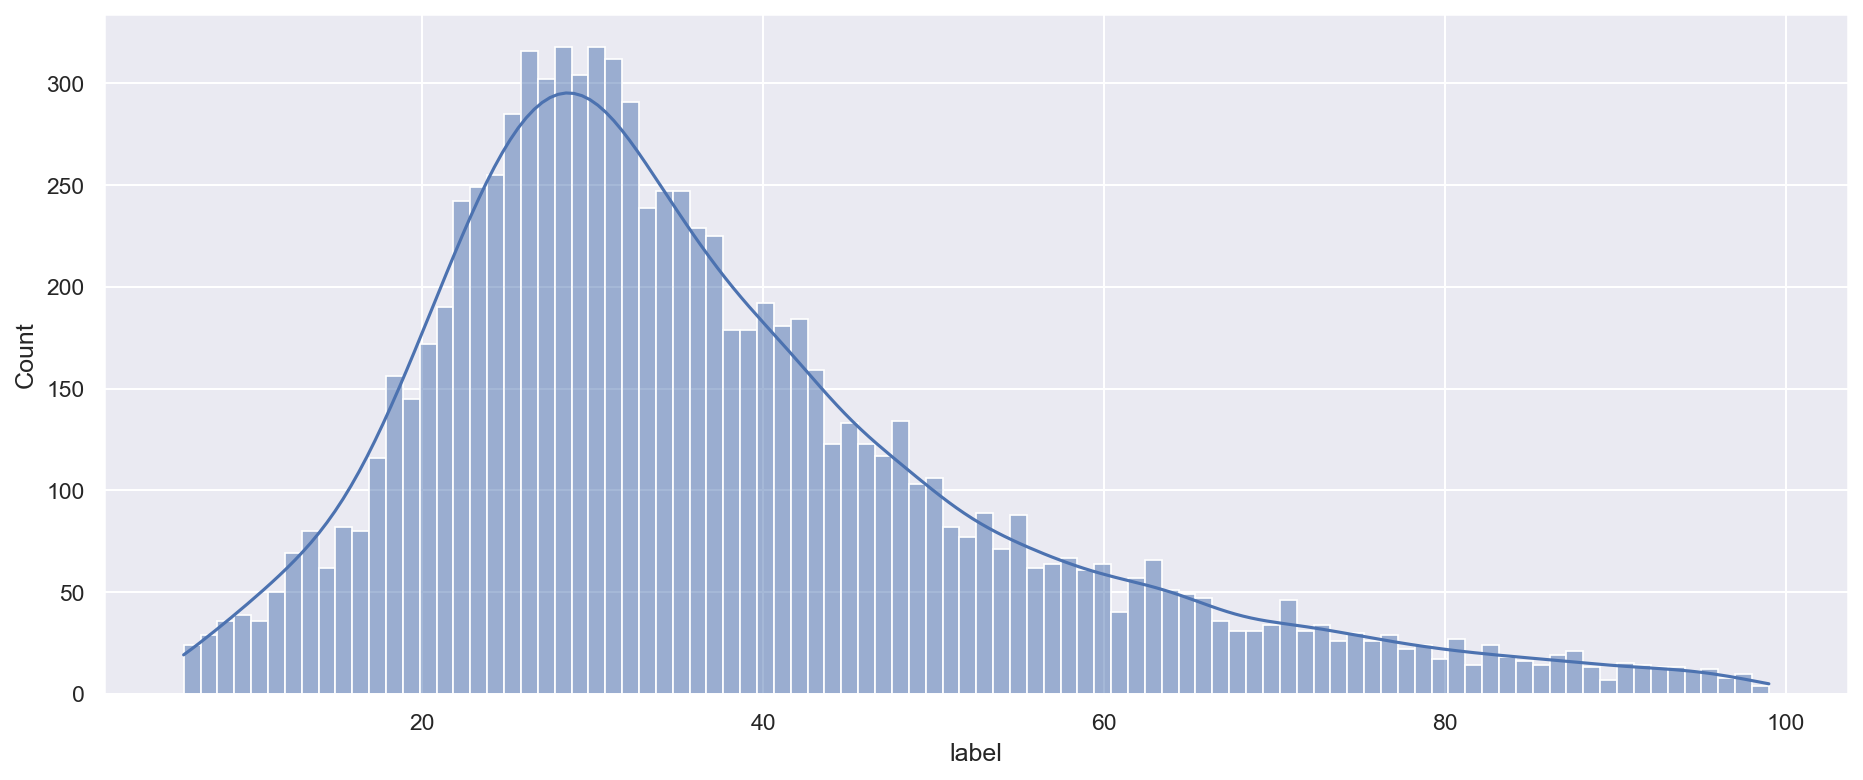

In [5]:
df = df[(df['label'] < 100) & (df['label'] > 5)]
figure(figsize = (15, 6), dpi = 150)
sns.set(style="darkgrid")
ax = sns.histplot(df, x = 'label', bins = 94, kde = True)
plt.show()

In [6]:
print(df[df['label'] == 5])
print(df[df['label'] == 100])

Empty DataFrame
Columns: [images, label]
Index: []
Empty DataFrame
Columns: [images, label]
Index: []


In [7]:
df['images'] = mypath + "/train/" + df['images'] + ".jpg" 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=11)
#print(train.iloc[0][0])
#print(test['images'])

In [8]:
#df['label'] = df['label'].astype('str')
#train['label'] = train['label'].astype('str')
#test['label'] = test['label'].astype('str')

In [9]:
print(train['label'])

2132    53
5305    44
736     52
1832    34
4910    34
        ..
1375    58
4266    63
7693     6
5513    31
4005    51
Name: label, Length: 7506, dtype: int32


In [10]:
# Create data generator for the images
# splitting into testing and training data
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, # normalize the image 
    rotation_range = 360, # augmentation of images (helps to avoid overfitting)
    width_shift_range=0.35,
    height_shift_range=0.35,
    shear_range = 0.35,
    zoom_range = 0.35,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

val_generator = ImageDataGenerator(rescale=1./255)

# TODO: can't seem to find documentation on what target_size does under hood
train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=64, 
    class_mode='raw'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=64, 
    class_mode='raw'
)

Found 7506 validated image filenames.
Found 1877 validated image filenames.



model2 = Sequential([
    Conv2D(64, (7,7), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((3,3)),
    Conv2D(16, (5,5), activation='relu'),
    MaxPool2D((3,3)),
    Conv2D(16, (4,4), activation='relu'),
    Conv2D(16, (2,2), activation='relu'),
    #Conv2D(256, (2,2), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(rate = 0.25),    
    Dense(2048, activation='sigmoid'),    
    Dense(1, activation='linear'),
])

In [11]:
# added tanh and doubled filters and made batch 1k
model = Sequential([
    Conv2D(128, (12,12), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((3,3)),
    Conv2D(256, (8,8), activation='relu'),
    MaxPool2D((3,3)),
    Conv2D(512, (5,5), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(1024, (2,2), activation='relu'),
    #Conv2D(2048, (2,2), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(rate = 0.5),    
    Dense(4096, activation='relu'),    
    Dropout(rate = 0.5),    
    Dense(2048, activation='relu'),    
    Dropout(rate = 0.5),    
    Dense(1048, activation='tanh'),    
    Dropout(rate = 0.5),    
    Dense(1, activation='linear'),
])

import tensorflow as tf
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])


#K.set_value(model.optimizer.learning_rate, 0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 117, 117, 128)     55424     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       2097408   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 512)         3277312   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 512)        0

In [12]:
history = model.fit(train_iterator, epochs=1, validation_data=val_iterator, shuffle=True)

118/118 [==============================] - 495s 4s/step - loss: 318.2393 - root_mean_squared_error: 17.8393 - val_loss: 276.9229 - val_root_mean_squared_error: 16.6410


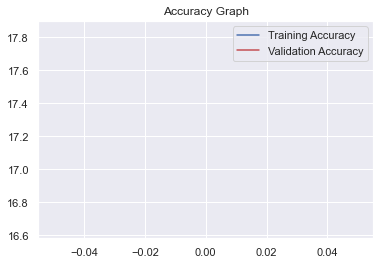

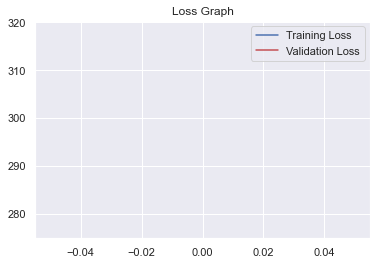

[16.641000747680664]


In [13]:
# Visualization of Results
accuracy = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


print(val_acc)

In [14]:
# save model and outputs
#np.savetxt('data.csv', (accuracy, val_acc, loss, val_loss), delimiter=',')
#model.save('seventeen_hr.h5')